# Import Lib

In [7]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from wordcloud import WordCloud


import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay, accuracy_score


# Import train & test data

In [9]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
combine = [train,test]

# Basic Analyze

In [10]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to ' shelter in place ' ...,1
3,6,NaN,NaN,"13,000 people receive # wildfires evacuation ...",1
4,7,NaN,NaN,Just got sent this photo from Ruby # Alaska a...,1


In [11]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about # earthquake is different cities,..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting . # Spokane # wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# Visualisation

C:\Users\Vaibhav\AppData\Local\Temp\ipykernel_15596\1599979911.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='target',palette='pastel')


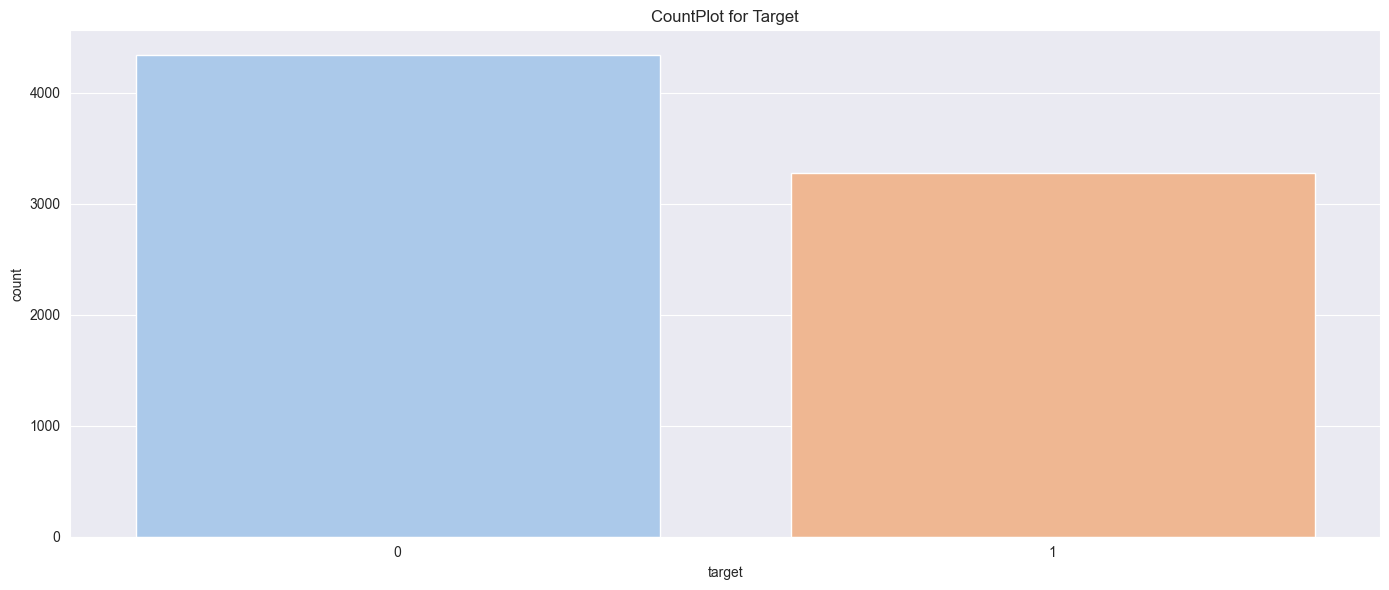

In [13]:
plt.figure(figsize=(14,6))
sns.set_style('darkgrid')
sns.countplot(data=train, x='target',palette='pastel')
plt.title('CountPlot for Target')
plt.tight_layout()
plt.show()


In [15]:
train['length'] = train['text'].apply(len)

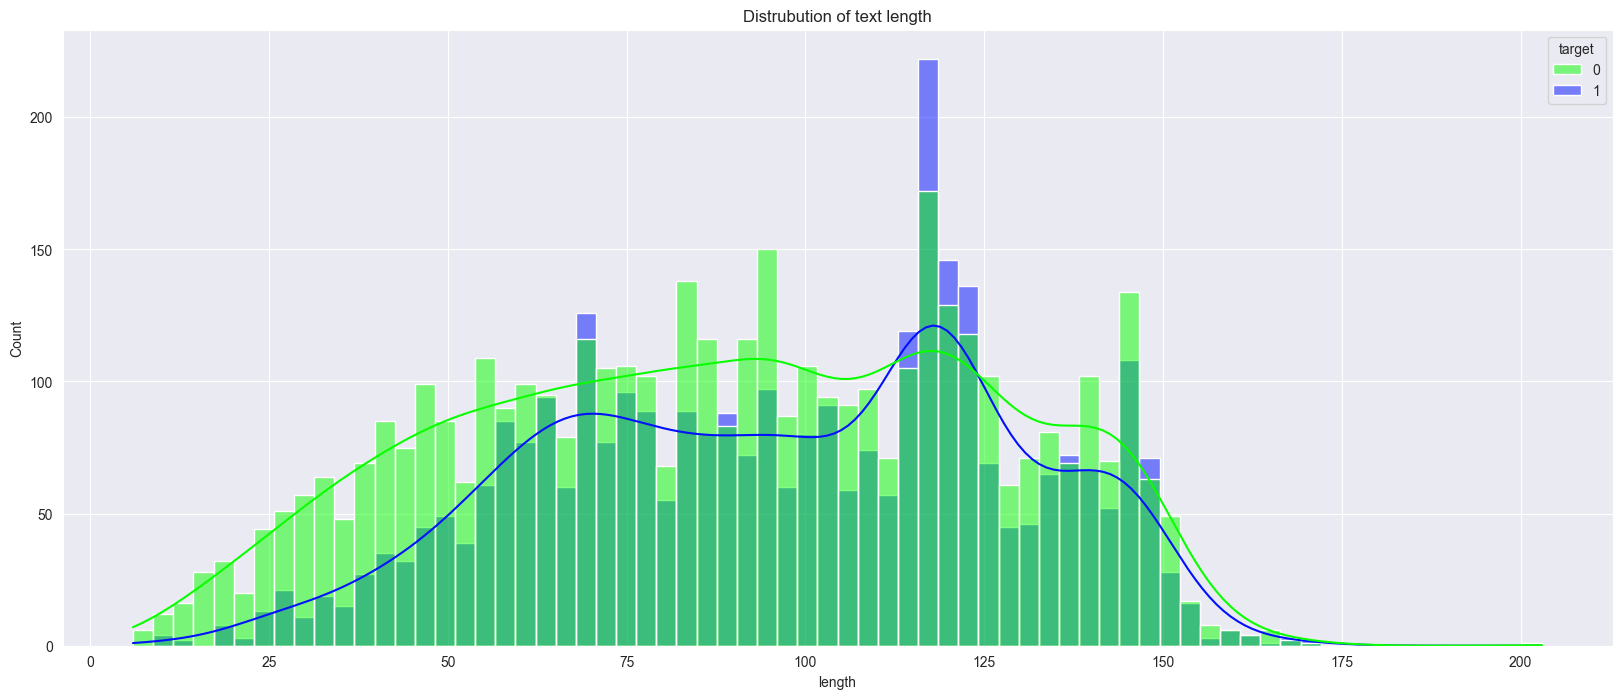

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(20,8))
sns.histplot(data=train,x='length',hue='target',palette='hsv',kde= True,bins=70)
plt.title('Distrubution of text length')
plt.show()
plt.tight_layout()

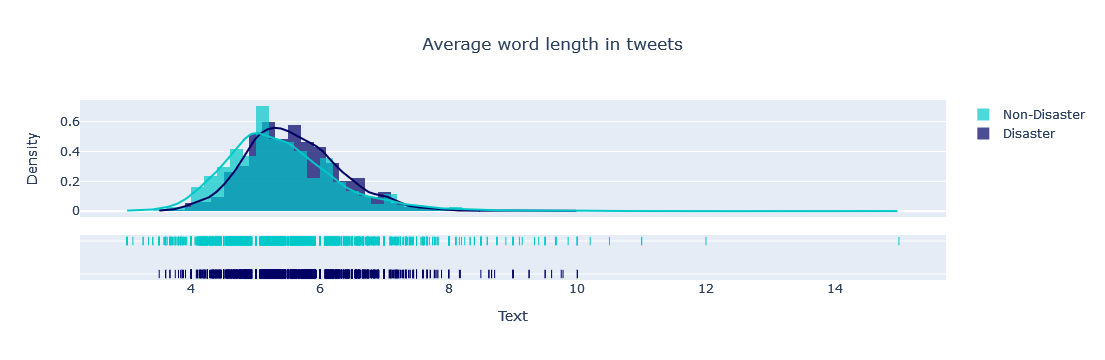

In [66]:
def avgwordlen(strlist):
    sum=[]
    for i in strlist:
        sum.append(len(i))
    return sum

avgword_len_dis = train[train['target']==1]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

avgword_len_non_dis = train[train['target']==0]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

group_labels = ['Disaster', 'Non-Disaster']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot([avgword_len_dis, avgword_len_non_dis], group_labels, bin_size=.2, colors=colors,)

fig.update_layout(title_text="Average word length in tweets",title_x=0.5,xaxis_title="Text",yaxis_title="Density").show()

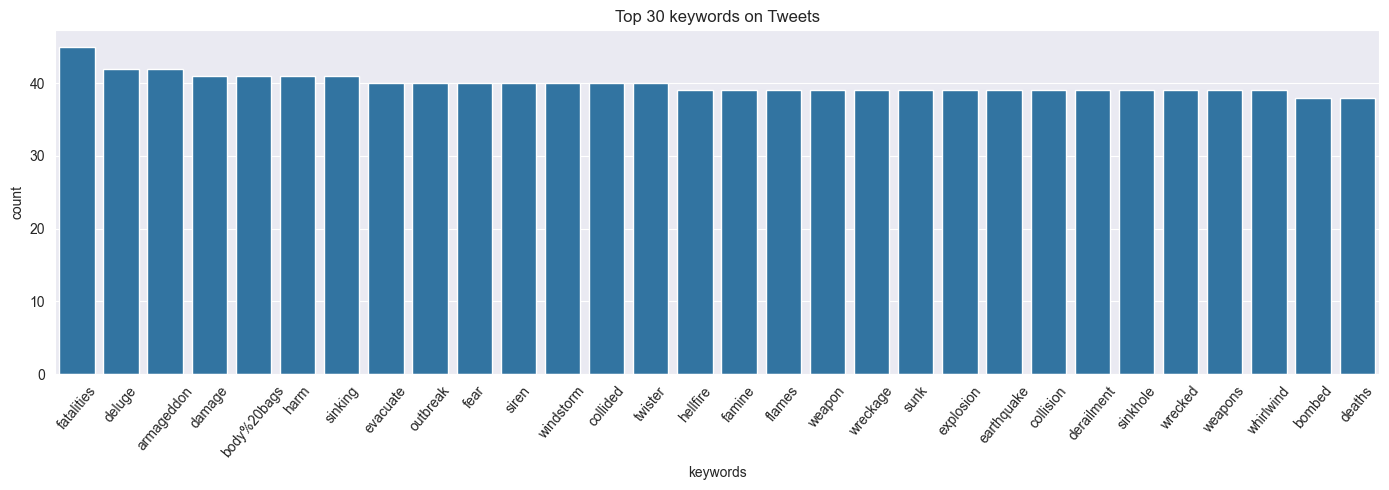

In [18]:
# Grouping by Keywords to see the count of keywords
keyword = train.groupby('keyword')['target'].count()
df_key = pd.DataFrame({'keywords':keyword.index,'count':keyword.values}).sort_values(by='count',ascending=False)

# Top 30 keywords in the Tweets.
plt.figure(figsize=(14,5))
sns.barplot(data=df_key.head(30),x='keywords',y='count')
plt.xticks(rotation = 50)
plt.title('Top 30 keywords on Tweets')
plt.tight_layout()
plt.show()

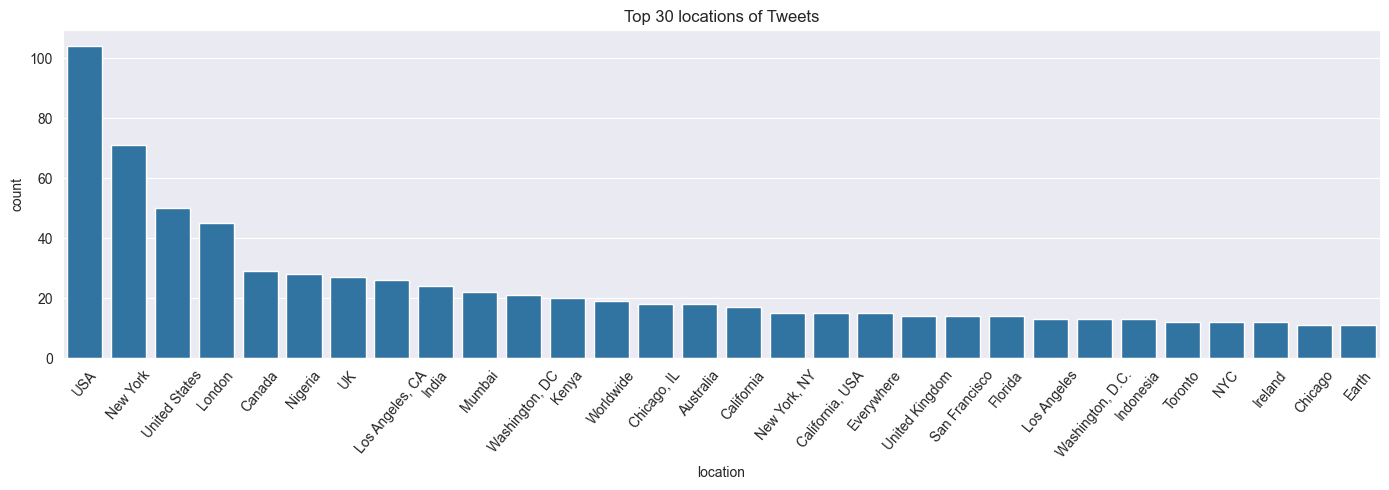

In [19]:
# Grouping by Location to find the count of each location
location = train.groupby('location')['target'].count()
df_loc = pd.DataFrame({'location':location.index,'count':location.values}).sort_values(by='count',ascending=False)

# Top 30 Location in the tweets
plt.figure(figsize=(14,5))
sns.barplot(data=df_loc.head(30),x='location',y='count')
plt.xticks(rotation = 50)
plt.title('Top 30 locations of Tweets')
plt.tight_layout()
plt.show()

# Fetaure Enginering

In [23]:
import nltk
nltk.download('stopwords')
stemmer = PorterStemmer()

def preprocess_data(data):
    
    #removal of url
    text = re.sub(r'https?://\\S+|www\\.\\S+|http?://\\S+', ' ', data)
    text = re.sub('@\\S+', '', text)
    
    #decontraction
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    
    #removal of html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    # Match all digits in the string and replace them by empty string
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    # filtering out miscellaneous text.
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = re.sub(r"\([^()]*\)", "", text)
    
    # remove mentions
    text = re.sub('@\S+', '', text)  
    
    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  
    

    # Lowering all the words in text
    text = text.lower()
    text = text.split()
    
    text = [stemmer.stem(words) for words in text if words not in stopwords.words('english')]
    
    # Removal of words with length<2
    text = [i for i in text if len(i)>2] 
    text = ' '.join(text)
    return text

<>:56: SyntaxWarning:

invalid escape sequence '\S'

<>:59: SyntaxWarning:

invalid escape sequence '\]'

<>:56: SyntaxWarning:

invalid escape sequence '\S'

<>:59: SyntaxWarning:

invalid escape sequence '\]'

C:\Users\Vaibhav\AppData\Local\Temp\ipykernel_15596\347172578.py:56: SyntaxWarning:

invalid escape sequence '\S'

C:\Users\Vaibhav\AppData\Local\Temp\ipykernel_15596\347172578.py:59: SyntaxWarning:

invalid escape sequence '\]'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaibhav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
train['text'] = train['text'].apply(preprocess_data)
test['text'] = test['text'].apply(preprocess_data)

In [25]:
disaster = ' '.join(train[train['target']==1]['text'])
non_disaster =''.join(train[train['target']==0]['text'])

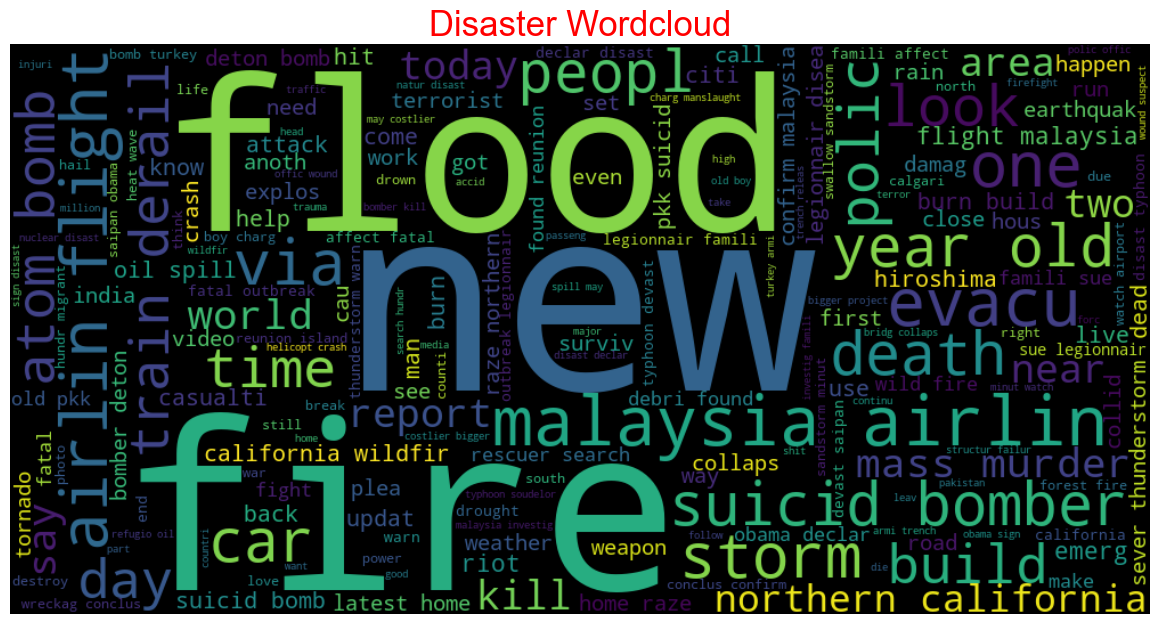

In [26]:
plt.figure(figsize=(14,6))
wordcloud = WordCloud(width=1000,height=500).generate(disaster)
plt.imshow(wordcloud,interpolation='bilinear',cmap='magma')
plt.axis('off')
plt.tight_layout()
plt.title('Disaster Wordcloud',fontsize= 25,color='Red')
plt.show()

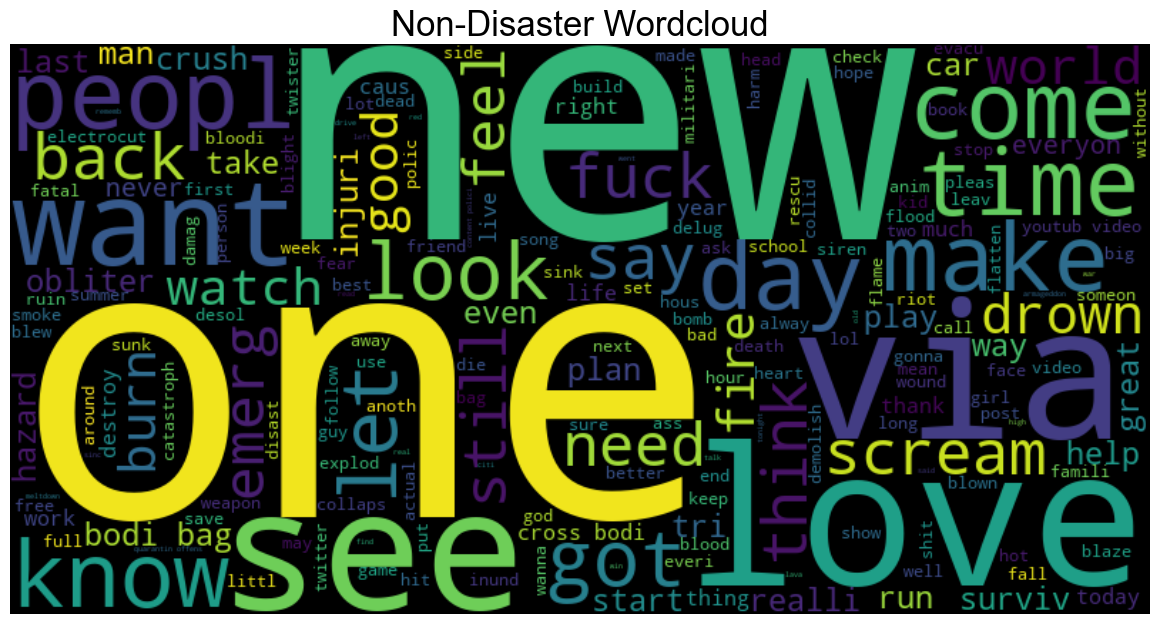

In [27]:
plt.figure(figsize=(14,6),frameon=True)
wordcloud = WordCloud(width=800,height=400).generate(non_disaster)
plt.imshow(wordcloud,interpolation='bilinear',cmap='Dark2')
plt.axis('off')
plt.tight_layout()
plt.title('Non-Disaster Wordcloud',fontsize= 25,color='Black')
plt.show()

# Train Test Split

In [28]:
data = pd.concat([train,test])
X = data['text']
y = train['target']

In [29]:
train.shape,test.shape

((7613, 6), (3263, 4))

In [30]:
tf = TfidfVectorizer()
data_vec=tf.fit_transform(X)
print(data_vec)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 93216 stored elements and shape (10876, 15749)>
  Coords	Values
  (0, 3449)	0.5132458965871212
  (0, 11250)	0.3608744624648511
  (0, 4117)	0.3390589954304157
  (0, 8564)	0.3117093125004608
  (0, 380)	0.43587248715558163
  (0, 5042)	0.4519289203361538
  (1, 5036)	0.3149147254794655
  (1, 4871)	0.2276698142988295
  (1, 9385)	0.32541397025395
  (1, 11726)	0.536053005207653
  (1, 11999)	0.536053005207653
  (1, 2076)	0.41035992800537757
  (2, 11467)	0.27389222492709303
  (2, 787)	0.2358700716625245
  (2, 12375)	0.5846693983106188
  (2, 10570)	0.4653175535323516
  (2, 9682)	0.3466368080095756
  (2, 9831)	0.22208098417953645
  (2, 4503)	0.18624258052597234
  (2, 10015)	0.22444926042763602
  (2, 4571)	0.2375895998638485
  (3, 4503)	0.35831605218600726
  (3, 10015)	0.4318226942806139
  (3, 10378)	0.3226709417754008
  (3, 11271)	0.54849037523872
  :	:
  (10872, 15351)	0.2447309123387613
  (10872, 13195)	0.20243832428688371
  (10872, 1

In [31]:
df_train =data_vec[:7613,:]
df_test = data_vec[7613:,:]

In [32]:
df_train.shape,df_test.shape

((7613, 15749), (3263, 15749))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_train , y, test_size=0.33, random_state=1)

# Models

In [36]:
lr = LogisticRegression()
svc = SVC(kernel='linear', degree=3, gamma='auto')
rf = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_split=2, n_estimators=50, random_state=42)
mnb = MultinomialNB()
grd = GradientBoostingClassifier()
xgb = XGBClassifier()

# Confusion Matrix and Model Accuracy

 # TP FN
# FP TN

# Logistic Regression

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1471
           1       0.86      0.65      0.74      1042

    accuracy                           0.81      2513
   macro avg       0.82      0.79      0.79      2513
weighted avg       0.82      0.81      0.80      2513



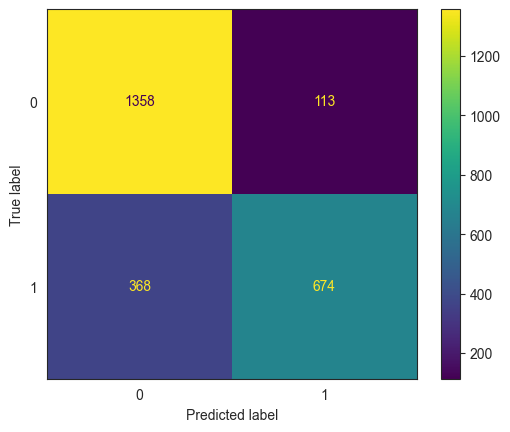

In [37]:
sns.set_style('white')
pipe_lr = make_pipeline(lr)
pipe_lr.fit(X_train,y_train)
pred = pipe_lr.predict(X_test)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
score_lr = accuracy_score(y_test,pred)

# SVC

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1471
           1       0.82      0.67      0.74      1042

    accuracy                           0.80      2513
   macro avg       0.81      0.78      0.79      2513
weighted avg       0.81      0.80      0.80      2513



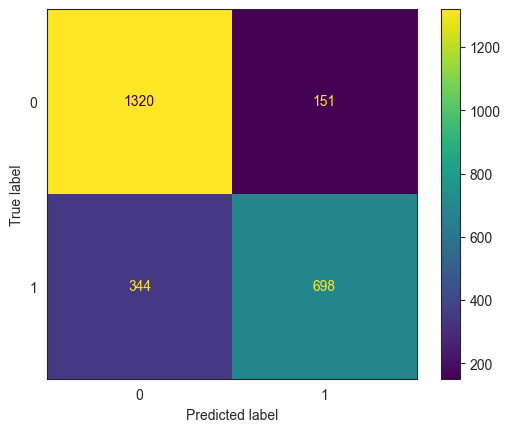

In [38]:
pipe_svc = make_pipeline(svc)
pipe_svc.fit(X_train,y_train)
pred = pipe_svc.predict(X_test)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
score_svc = accuracy_score(y_test,pred)

# Random Forest Classifier

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1471
           1       0.99      0.20      0.34      1042

    accuracy                           0.67      2513
   macro avg       0.81      0.60      0.56      2513
weighted avg       0.78      0.67      0.60      2513



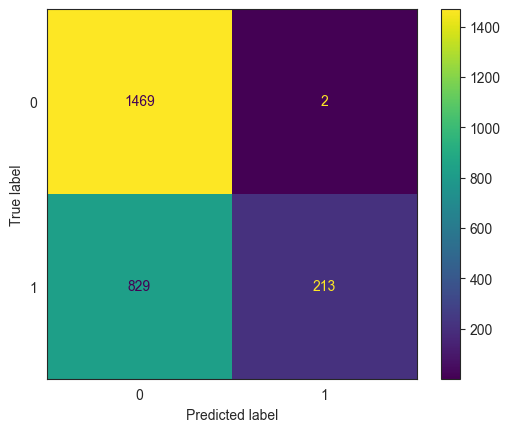

In [39]:
pipe_rf = make_pipeline(rf)
pipe_rf.fit(X_train,y_train)
pred = pipe_rf.predict(X_test)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
score_rf = accuracy_score(y_test,pred)

# Multinomial NB

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1471
           1       0.84      0.66      0.74      1042

    accuracy                           0.81      2513
   macro avg       0.82      0.79      0.79      2513
weighted avg       0.81      0.81      0.80      2513



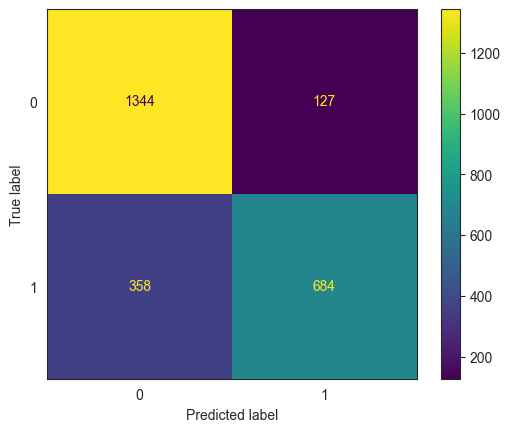

In [40]:
pipe_mnb = make_pipeline(mnb)
pipe_mnb.fit(X_train,y_train)
pred = pipe_mnb.predict(X_test)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
score_mnb = accuracy_score(y_test,pred)

# Gradiant Boosting Classifier

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      1471
           1       0.83      0.51      0.63      1042

    accuracy                           0.75      2513
   macro avg       0.78      0.72      0.72      2513
weighted avg       0.77      0.75      0.74      2513



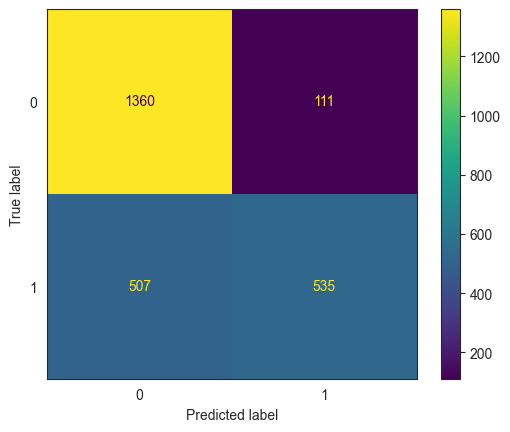

In [41]:
pipe_grd = make_pipeline(grd)
pipe_grd.fit(X_train,y_train)
pred = pipe_grd.predict(X_test)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
score_grd = accuracy_score(y_test,pred)

# XG Boost

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1471
           1       0.78      0.64      0.70      1042

    accuracy                           0.77      2513
   macro avg       0.77      0.75      0.76      2513
weighted avg       0.77      0.77      0.77      2513



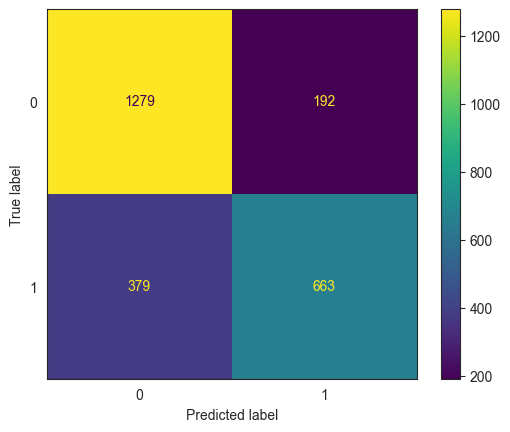

In [42]:
pipe_xgb = make_pipeline(xgb)
pipe_xgb.fit(X_train,y_train)
pred = pipe_xgb.predict(X_test)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
score_xgb = accuracy_score(y_test,pred)

# Voting Classifier

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1471
           1       0.85      0.66      0.74      1042

    accuracy                           0.81      2513
   macro avg       0.82      0.79      0.80      2513
weighted avg       0.82      0.81      0.81      2513



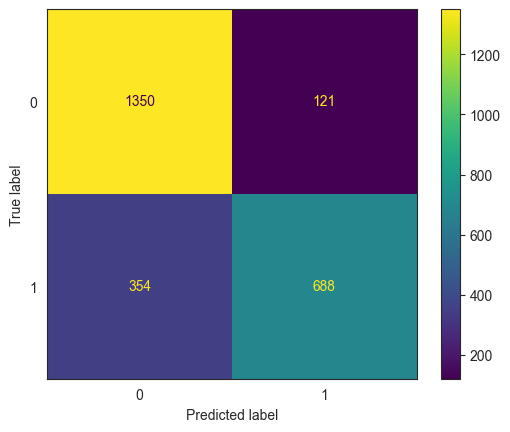

In [44]:
pipe_vt = VotingClassifier(estimators=[('lr',lr),('svc',svc),('mnb',mnb)],voting='hard')
pipe_vt.fit(X_train,y_train)
pred_vt = pipe_vt.predict(X_test)
print(classification_report(y_test,pred_vt))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred_vt)).plot()
score_vt = accuracy_score(y_test,pred)

In [45]:
data = {'modles': ['Logistic Regression','SVC','Random Forest Classifier','Multinomial NB','Gradient Boosting Classifier','XGB Classifier','Voting Classifier'],
        'Score': [score_lr,score_svc,score_rf,score_mnb,score_grd,score_xgb,score_vt]}
df =pd.DataFrame(data)
df['Score'] =df['Score']*100
df.sort_values(by='Score',ascending=False)

,modles,Score
0,Logistic Regression,80.859530
3,Multinomial NB,80.700358
1,SVC,80.302427
6,Voting Classifier,77.278154
5,XGB Classifier,77.278154
4,Gradient Boosting Classifier,75.407879
2,Random Forest Classifier,66.931954


# Submission

In [59]:
submision = pd.read_csv('sample_submission.csv')

In [60]:
predict = pipe_mnb.predict(df_test)

In [61]:
submision.target = predict

In [63]:
submision.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


In [70]:
submision.head(50)

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [53]:
submision.to_csv('submission.csv',index=False)